# 🧮 Neural Networks Extension in Poisson Pricing

### 📘 Project Overview
Questo notebook continua quanto iniziato nel notebook precedente (**[PoissonPricing](https://github.com/matteopastore024-dot/Insurance-project/blob/main/PoissonPricing.ipynb)**).
Qui vengono introdotti e testati diversi approcci di modellazione ibrida, culminando nell’implementazione del modello **CANN** descritto in:

> Schelldorfer, Jürg, and Mario V. Wuthrich. "Nesting classical actuarial models into neural networks." Available at SSRN 3320525 (2019).
---

### ⚙️ Notebook Structure

#### **1. Solving the Bias Problem**  
Osservando che in caso di utilizzo di una rete neurale non è garantita la full allocation property:
$$\sum_{i=1}^n N_i \neq \sum_{i=1}^n \lambda_{nn_{estimate}} \text{Exposure}_i $$ 
A differenza della stima dei parametri sotto le ipotesi del GLM, dove la proprietà è garantita dall'esistenza dell'intercetta e dal fatto che i coefficienti stimati nel GLM sono punti critici del modello. 
Per risolvere il problema si trattano gli output del layer3 del modello nn_deep introdotto in **[PoissonPricing](https://github.com/matteopastore024-dot/Insurance-project/blob/main/PoissonPricing.ipynb)** come se fossero delle rielaborazioni degli input; queste diventano regressori di un nuovo GLM che permetterà di ottenere la full allocation property.

---

#### **2. Blendig Neural Network Models Predictions**  
Ispirati alle tecniche di Ensemble learning, vengono stimati 12 neural network deep con diverso numero di neuroni, ipotizzando che tutti i modelli siano validi, la stima finale sarà data dalla media delle predizioni dei 12 nn. Si applica ad ogni neural network la bias correction della sezione 1 per ottenere la full allocation property. 


---

#### **3. Boosting Challenge**  
Dopo aver stimato il blended network si prova ad applicare la procedura di boosting simile a quella esposta in **[PoissonPricing](https://github.com/matteopastore024-dot/Insurance-project/blob/main/PoissonPricing.ipynb)**, nello specifico si provano tre procedure di boosting che si differenziano unicamente per il numero massimo di split degli alberi ai diversi passaggi di boosting: J = 1,2,3. Il numero ottimale di split è determinato utilizzando una 10-fold cross-validation. La procedura è applicata nel seguente modo:  

- Costruzione dei 10 blocchi a partire dal training set.
- Si fissa un ccp a $10^{-5}$ e un numero massimo di step di boost a 30.
- Per ogni combinazione di 9-1 blocchi si eseguono i 30 passaggi di boosting e si calcola la validation loss.
- Si calcola la CV loss come validation loss media e la CV standard deviation come std della validation loss ad ogni step di boosting.  
Il numero ottimale di step di boosting è selezionato scegliendo il numero di step più basso per cui la CV loss è compresa in una banda di standard deviation dal modello  con CV loss più bassa.
---

#### **4. Combined Actuarial Neural Network (CANN)**
L'obbiettivo di questa procedura è individuare la miglior trasformazione non lineare per i regressori al fine di catturare tutta l'informazione disponibile nel dataset. Partendo dal modello `GLM1` di **[PoissonPricing](https://github.com/matteopastore024-dot/Insurance-project/blob/main/PoissonPricing.ipynb)** si estende questo modello con una rete neurale basata sugli stessi regressori:
$$
x \;\mapsto\; \lambda(x) = \exp\!\left(\color{red}{ \hat{\beta}^{\top} x} \;+\; \color{blue}{{w^{(k+1)}}^{\top} \big( z^{(k)} \circ \dots \circ z^{(1)} \big)}(x) \right)
$$
- Inizializzazione della parte <span style="color:red">GLM</span> con i coefficienti stimati in `GLM1`.  
- I pesi del layer `GLM1`vengono fissati e non saranno addestrati  (si possono inizializzare e addestrare successivamente).  
- Aggiunta di una componente <span style="color:blue">Neural Network</span> con struttura identica a nn_deep, con:
  - regressori scalati tra [-1,1],
  - embedding per `Region` e `VehBrand`,
  - funzione di attivazione `tanh`.  
- Training con loss **Poisson** e confronto finale con il GLM puro.

---
#### **5. CANN trainable**  
In questo modello la procedura è identica al passo precedente, solo che dopo aver inizializzato i pesi della parte GLM con le stime `GLM1` si permette alla rete di ottimizzare anche questi pesi.

---
### 📊 **Results Summary**
| Model | In-sample Loss | Out-of-sample Loss | Notes |
|-------|----------------|-------------------|-------|
| GLM1 | 0.314087 | 0.317888 | Modello GLM base |
| GLM2 | 0.313944 | 0.317939 | Effetto di trasformazioni su DrivAge |
| NN Deep | 0.305335 | 0.312741   | Rete neurale pura |
| NN + GLM (blended) | 0.302522 | 0.310649 | Ensemble ibrido |
| 1st boosting step depth J0=3 | 0.301595 | 0.309956 | 1 iterazione sufficiente |
| CANN | 0.303659 |  0.311587 | Rielaborazione input |
| CANN (parte glm trainabile)| 0.305319 |  0.311900 | Rischio overfit maggiore |

 
---

### 🧩 **Main Contributions**
- Implementazione completa del pipeline GLM → NN → GLM(NN) → Blend → Boost → CANN.    
- Cross valida automatica per la scelta della profondità dell’albero.  
- Introduzione di embedding categoriali e blocchi GLM congelati in architettura Keras.  
- Analisi grafica e comparativa delle performance in-sample e out-of-sample.

---

### 📚 **References**
- Schelldorfer, J., & Wüthrich, M. V. (2019). *Nesting classical actuarial models into neural networks.* SSRN 3320525.  
- Ferrario, A., Mazza, R., & Wüthrich, M. V. (2020). *Insights from inside neural networks.* SSRN 3543173.  
- Wüthrich, M. V. (2021). *Machine learning in individual claims reserving.*  
- Keras Documentation: [https://keras.io](https://keras.io)

---

💡 *Questo notebook è pensato come un’estensione sperimentale a scopo didattico e di ricerca.  
Tutti i modelli sono sviluppati in TensorFlow/Keras e confrontati con GLM Poisson standard stimati con statsmodels.*


In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tensorflow.keras.layers import Input, Dense, Multiply, Embedding, Add, Concatenate, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance
from sklearn.tree import DecisionTreeRegressor, plot_tree
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.autolayout'] = True

Ricostruzione degli input del modello nn_deep

In [3]:
DATASET = pd.read_csv("freMTPL2freq.csv")
DATASET["AreaGLM"] = DATASET["Area"].astype("category").cat.codes
DATASET = DATASET.drop(columns="Area")
DATASET["VehAge"] = np.minimum(DATASET["VehAge"],20)
DATASET["DrivAge"] = np.minimum(DATASET["DrivAge"],90)
DATASET["BonusMalus"] = np.minimum(DATASET["BonusMalus"], 150)
DATASET["Density"] = np.log(DATASET["Density"])
DATASET["VehGas"] = (DATASET["VehGas"] == "Diesel").astype("int")  - .5
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["Region"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="Region")
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["VehBrand"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="VehBrand")

random.seed(100)
ll = random.sample(range(DATASET.shape[0]-1), round(DATASET.shape[0]*0.9 ))
train = DATASET.loc[ll,:]
test = DATASET.drop(index=ll)
X = train.iloc[:,3:]
X_test = test.iloc[:,3:]
y = train["ClaimNb"]

#si scalano i regressori diversi dalle dummy e da exposure tra -1 e 1
scaler = MinMaxScaler()
X_trainSC = pd.DataFrame(2 * scaler.fit_transform(X.iloc[:,0:7])-1)
X_testSC = pd.DataFrame(2 * scaler.transform(X_test.iloc[:,0:7]) -1)
X_trainSC.columns = X_testSC.columns = X.columns[0:7]
X_trainSC.index = X.index
X_testSC.index = X_test.index
X_trainSC = pd.concat([X_trainSC,X.iloc[:,7:]],axis = 1)
X_testSC = pd.concat([X_testSC,X_test.iloc[:,7:]],axis = 1)

model_input = Input(shape = (X_trainSC.shape[1],), name = "regressori", dtype = "float32")
exposure_input = Input(shape = (1,), name = "exposure")
x = Dense(20, activation = "tanh", name = "layer1")(model_input)
x = Dense(15, activation = "tanh", name = "layer2")(x)
x = Dense(10, activation = "tanh", name = "layer3")(x)
x = Dense(1, activation ="exponential" )(x)
output = Multiply()([x,exposure_input])
nn_deep = Model(inputs = [model_input,exposure_input], outputs = output)
nn_deep.load_weights("nn.weights_deep.weights.h5")
prediction_train_nndeep = nn_deep.predict(x = [X_trainSC,train["Exposure"]], verbose = 0)

print(f"Numero claim effettivo: {train['ClaimNb'].sum()}")
print(f"Somma dei \u03BBv stimati: {int(prediction_train_nndeep.sum())}")


Numero claim effettivo: 32489
Somma dei λv stimati: 32257


## Solving the bias problem

In [4]:
intermediate_model = Model(inputs=[model_input,exposure_input], outputs=nn_deep.get_layer("layer3").output)
intermediate_model.load_weights("nn.weights_deep.weights.h5")

RRnn_Deep_train = pd.DataFrame(intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0))
RRnn_Deep_test = pd.DataFrame(intermediate_model.predict(x=[X_testSC, test["Exposure"]] ,verbose=0))
RRnn_Deep_train.columns = [f"Var{i}" for i in range(10)]
RRnn_Deep_test.columns = [f"Var{i}" for i in range(10)]

New_data_train = pd.concat([train["ClaimNb"].reset_index(drop=True),RRnn_Deep_train], axis = 1)
New_data_test = pd.concat([test["ClaimNb"].reset_index(drop=True),RRnn_Deep_test], axis = 1)


try:
    model = smf.glm(formula="ClaimNb ~ Var0 + Var1 + Var2 + Var3 + Var4 + Var5 + Var6 + Var7 + Var8 + Var9",
                family = sm.families.Poisson(), data = New_data_train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
model1 = model.fit()
print(model1.summary())
prediction1 = model1.predict(New_data_test, offset= np.log(test["Exposure"]))
print(f"Numero claim effettivo: {train['ClaimNb'].sum()}")
print(f"Somma dei \u03BBv stimati: {model1.mu.sum()}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610201
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2430e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.8623e+05
Time:                        15:42:54   Pearson chi2:                 1.40e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02534
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0380      0.060     -0.630      0.5

## Blendig Neural Networks

In [6]:
#---------Blending NN Predictions --------------

def Buildmodel(params):
    model_input = Input(shape=(X_trainSC.shape[1],), name="regressori", dtype="float32")
    exposure_input = Input(shape=(1,), name="exposure")
    x = Dense(params[0], activation="tanh", name="layer1")(model_input)
    x = Dense(params[1], activation="tanh", name="layer2")(x)
    x = Dense(params[2], activation="tanh", name="layer3")(x)
    x = Dense(1, activation="exponential")(x)
    output = Multiply()([x, exposure_input])
    nn = Model(inputs=[model_input, exposure_input], outputs=output)
    nn.compile(loss="poisson", optimizer=Nadam())
    return nn
param_grid = np.concatenate([np.repeat(10,6),np.repeat(20,6)], axis=0)
param_grid = np.concatenate([param_grid.reshape(-1,1),
                             np.array([10,10,15,15,20,20,10,10,15,15,20,20]).reshape(-1,1),
                             np.array([10,20,10,20,10,20,10,20,10,20,10,20]).reshape(-1,1)], axis = 1)

loss = []
oos_loss = []
loss_nn_glm = []
oos_loss_glm = []
n_param = []

pred_blend_train = np.zeros(shape = (train.shape[0] ,param_grid.shape[0]))
pred_blend_test = np.zeros(shape = (test.shape[0] ,param_grid.shape[0]))

for i in range(param_grid.shape[0]):
    print(i)
    model_ensamble = Buildmodel(param_grid[i,:])
    checkpoint_path = f"nn.weights_ensamble{i}.weights.h5"

    checkpoint1 = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True
    )

    fit = model_ensamble.fit(
        x=[X_trainSC, train["Exposure"]],
        y=y,
        validation_split=0.2,
        batch_size=5000,
        epochs=1000,
        verbose=0,
        callbacks=[checkpoint1]
    )
    model_ensamble.load_weights(checkpoint_path)

    prediction_train = model_ensamble.predict(x = [X_trainSC, train["Exposure"]],verbose = 0)
    prediction_test = model_ensamble.predict(x = [X_testSC, test["Exposure"]], verbose = 0)

    loss.append(mean_poisson_deviance(train["ClaimNb"], prediction_train))
    oos_loss.append(mean_poisson_deviance(test["ClaimNb"], prediction_test))
    n_param.append(model_ensamble.count_params())

    intermediate_model = Model(inputs = [model_ensamble.get_layer("regressori").output, model_ensamble.get_layer("exposure").output], outputs = model_ensamble.get_layer("layer3").output )
    intermediate_model.load_weights(checkpoint_path)

    X_train_int = pd.DataFrame(intermediate_model.predict(x = [X_trainSC, train["Exposure"]],verbose = 0))
    X_test_int  = pd.DataFrame(intermediate_model.predict(x = [X_testSC, test["Exposure"]],verbose = 0))

    X_train_int.columns = [f"Var{i}" for i in range(param_grid[i,-1])]
    X_test_int.columns = [f"Var{i}" for i in range(param_grid[i,-1])]

    formula = f"ClaimNb ~  {'+'.join(X_train_int.columns)}"

    X_train_int = pd.concat([train["ClaimNb"].reset_index(drop=True), X_train_int], axis = 1)
    X_test_int = pd.concat([test["ClaimNb"].reset_index(drop=True), X_test_int], axis = 1)

    try:
        model = smf.glm(formula=formula,
                        family=sm.families.Poisson(), data=X_train_int, offset=np.log(train["Exposure"]))
    except Exception as e:
        print("errore")
        print(e)
    model1 = model.fit()
    prediction_train = model1.mu
    prediction_test = model1.predict(X_test_int, offset=np.log(test["Exposure"].reset_index(drop=True)))

    pred_blend_train[:,i] = prediction_train
    pred_blend_test[:,i] = np.array(prediction_test)

    loss_nn_glm.append(mean_poisson_deviance(train["ClaimNb"], prediction_train))
    oos_loss_glm.append(mean_poisson_deviance(test["ClaimNb"], prediction_test))

    Tabella = pd.concat([pd.DataFrame(np.array(n_param)),
                     pd.DataFrame(np.array(loss)),
                     pd.DataFrame(np.array(oos_loss)),
                     pd.DataFrame(np.array(loss_nn_glm)),
                     pd.DataFrame(np.array(oos_loss_glm))],axis=1)
Tabella.index = [f"(q1, q2, q3) = {param_grid[i,:]}" for i in range(param_grid.shape[0])]
Tabella.columns = ["Param Number","No reg In-Sample loss", "No reg Oos loss","reg loss","reg Oos loss"]
print(Tabella.iloc[:,1:])

train_blend_pred = pred_blend_train.mean(axis = 1)
test_blend_pred = pred_blend_test.mean(axis = 1)
print(f"blended model in-sample loss: {mean_poisson_deviance(train['ClaimNb'], train_blend_pred)}")
print(f"blended model out-of-sample loss: {mean_poisson_deviance(test['ClaimNb'], test_blend_pred)}")
train_blend_pred = pd.Series(train_blend_pred)
test_blend_pred = pd.Series(test_blend_pred)
train_blend_pred.index = train.index
test_blend_pred.index = test.index



0
1
2
3
4
5
6
7
8
9
10
11
                           No reg In-Sample loss  No reg Oos loss  reg loss  \
(q1, q2, q3) = [10 10 10]               0.304872         0.312072  0.304854   
(q1, q2, q3) = [10 10 20]               0.305763         0.313405  0.305694   
(q1, q2, q3) = [10 15 10]               0.305357         0.312127  0.305300   
(q1, q2, q3) = [10 15 20]               0.304745         0.312529  0.304692   
(q1, q2, q3) = [10 20 10]               0.304371         0.311918  0.304335   
(q1, q2, q3) = [10 20 20]               0.303933         0.312266  0.303901   
(q1, q2, q3) = [20 10 10]               0.306131         0.313599  0.305992   
(q1, q2, q3) = [20 10 20]               0.303955         0.312680  0.303858   
(q1, q2, q3) = [20 15 10]               0.304795         0.312597  0.304709   
(q1, q2, q3) = [20 15 20]               0.305214         0.312909  0.305100   
(q1, q2, q3) = [20 20 10]               0.303454         0.313657  0.303414   
(q1, q2, q3) = [20 20 20] 

## Boosting Challenge

In [ ]:
random.seed(100)
valori = np.array(X_trainSC.index)
kfold = 10
size = round(len(valori)/10)
blocchi_X = []
blocchi_y =[]
blocchi_exposure = []

for i in range(kfold-1):
    indici = np.random.choice(valori,size=size, replace=False)
    blocchi_X.append(X_trainSC.loc[indici,:])
    blocchi_y.append(y.loc[indici])
    blocchi_exposure.append(train_blend_pred.loc[indici])
    valori = np.setdiff1d(valori,indici)
blocchi_X.append(X_trainSC.loc[indici,:])
blocchi_y.append(y.loc[indici])
blocchi_exposure.append(train_blend_pred.loc[indici])

#costruzione dell'albero più grosso
ccp = 10**(-5) #ccp massimo fissato
boosting_iterations = 30
boosting_number = np.arange(boosting_iterations)+1
fold = np.arange(kfold)
J = [1,2,3] #max depth

cv_mean = []
cv_std = []
for J0 in J:
    cv_loss = np.zeros(shape=(kfold,boosting_iterations))
    for i in range(kfold):
        fold_k = np.delete(fold, i)
        Xk = pd.concat([blocchi_X[j] for j in fold_k], axis=0)
        yk = pd.concat([blocchi_y[j] for j in fold_k], axis=0)
        exposurek = pd.concat([blocchi_exposure[j] for j in fold_k], axis=0)
        Xval = blocchi_X[i]
        yval = blocchi_y[i]
        exposureval = blocchi_exposure[i]

        pred_train = exposurek.copy()
        pred_val = exposureval.copy()

        for boost_step in range(boosting_iterations):

            y_boosting = yk / pred_train

            treeCVBoost = DecisionTreeRegressor(
                criterion="poisson",
                min_samples_leaf=5000,
                max_depth= J0,
                ccp_alpha=ccp,
            )
            treeCVBoost.fit(Xk, y_boosting, sample_weight=exposurek)
            previsioni = treeCVBoost.predict(Xk)
            previsioni_val = treeCVBoost.predict(Xval)
            # si aggiustano le exposure per il passo successivo
            pred_train = pred_train * previsioni
            pred_val = pred_val * previsioni_val
            cv_loss[i,boost_step] = mean_poisson_deviance(yval,pred_val.values)

    cv_mean.append(np.mean(cv_loss,axis = 0))
    cv_std.append(np.std(cv_loss, axis=0, ddof=1))


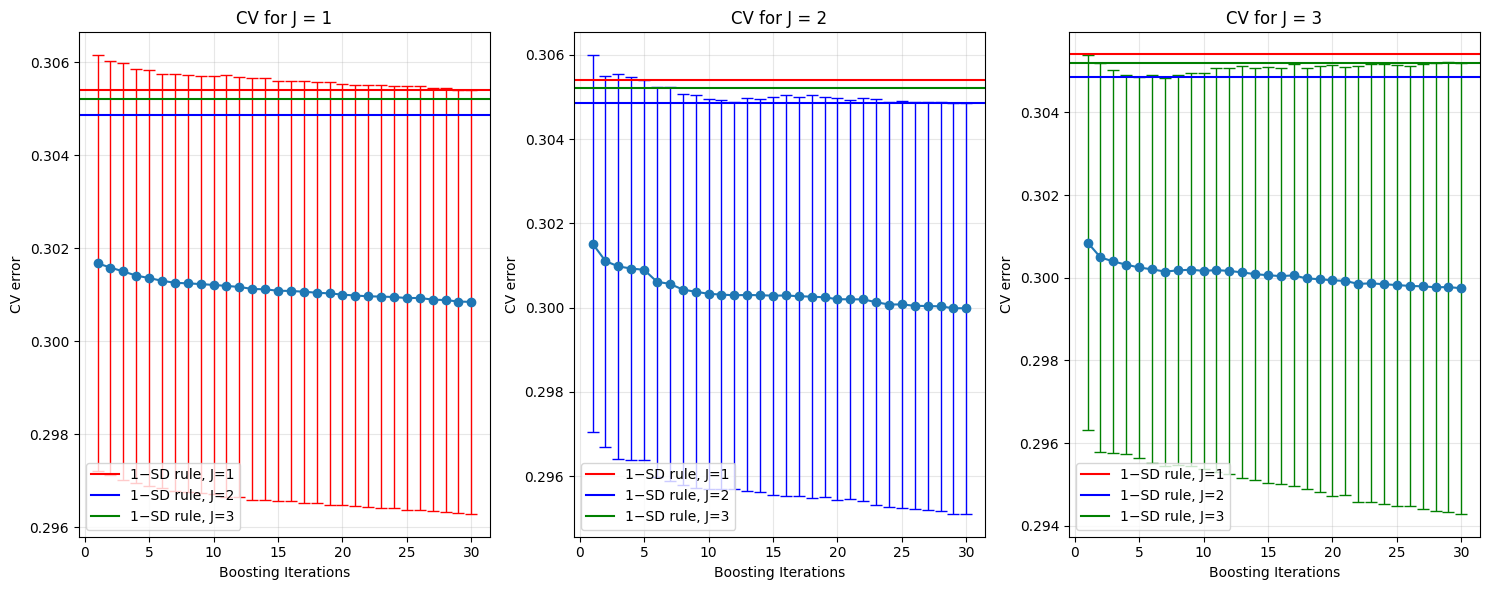

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].errorbar(boosting_number, cv_mean[0], yerr = cv_std[0],
               fmt='o-',
               ecolor='red',
               elinewidth=1, capsize=4,
               capthick=1,
               )
ax[0].axhline(y=min(cv_mean[0]) +  cv_std[0][cv_mean[0]==min(cv_mean[0])], xmin=0, xmax=1, color = "red", label = "1−SD rule, J=1")
ax[0].axhline(y=min(cv_mean[1]) +  cv_std[1][cv_mean[1]==min(cv_mean[1])], xmin=0, xmax=1, color = "blue",label = "1−SD rule, J=2")
ax[0].axhline(y=min(cv_mean[2]) +  cv_std[2][cv_mean[2]==min(cv_mean[2])], xmin=0, xmax=1, color = "green",label = "1−SD rule, J=3")
ax[0].grid(alpha=.3)
ax[0].legend()
ax[0].set_xlabel("Boosting Iterations")
ax[0].set_ylabel("CV error")
ax[0].set_title("CV for J = 1")

ax[1].errorbar(boosting_number, cv_mean[1], yerr = cv_std[1],
               fmt='o-',
               ecolor='blue',
               elinewidth=1, capsize=4,
               capthick=1,
               )
ax[1].axhline(y=min(cv_mean[0]) +  cv_std[0][cv_mean[0]==min(cv_mean[0])], xmin=0, xmax=1, color = "red",label = "1−SD rule, J=1")
ax[1].axhline(y=min(cv_mean[1]) +  cv_std[1][cv_mean[1]==min(cv_mean[1])], xmin=0, xmax=1, color = "blue",label = "1−SD rule, J=2")
ax[1].axhline(y=min(cv_mean[2]) +  cv_std[2][cv_mean[2]==min(cv_mean[2])], xmin=0, xmax=1, color = "green",label = "1−SD rule, J=3")
ax[1].grid(alpha=.3)
ax[1].legend()
ax[1].set_xlabel("Boosting Iterations")
ax[1].set_ylabel("CV error")
ax[1].set_title("CV for J = 2")

ax[2].errorbar(boosting_number, cv_mean[2], yerr = cv_std[2],
               fmt='o-',
               ecolor='green',
               elinewidth=1, capsize=4,
               capthick=1,
               )
ax[2].axhline(y=min(cv_mean[0]) +  cv_std[0][cv_mean[0]==min(cv_mean[0])], xmin=0, xmax=1, color = "red",label = "1−SD rule, J=1")
ax[2].axhline(y=min(cv_mean[1]) +  cv_std[1][cv_mean[1]==min(cv_mean[1])], xmin=0, xmax=1, color = "blue",label = "1−SD rule, J=2")
ax[2].axhline(y=min(cv_mean[2]) +  cv_std[2][cv_mean[2]==min(cv_mean[2])], xmin=0, xmax=1, color = "green",label = "1−SD rule, J=3")
ax[2].grid(alpha=.3)
ax[2].legend()
ax[2].set_xlabel("Boosting Iterations")
ax[2].set_ylabel("CV error")
ax[2].set_title("CV for J = 3")

plt.tight_layout()
plt.show(block=True)


Il plot segnala una sola boosting iteration necessaria per tutte le depth, non giustifica i successivi passaggi di boost

In [10]:
loss_boost = np.zeros(shape=(4))
loss_boost[0] = mean_poisson_deviance(train["ClaimNb"], train_blend_pred)
oos_loss_boost = np.zeros(shape=(4))
oos_loss_boost[0] = mean_poisson_deviance(test["ClaimNb"], test_blend_pred)
prediction_test = []
for J0 in J:
    pred_train = train_blend_pred.copy()
    pred_test = test_blend_pred.copy()

    y_boosting = train["ClaimNb"] / pred_train

    treeCVBoost = DecisionTreeRegressor(
        criterion="poisson",
        min_samples_leaf=5000,
        max_depth= J0,
        ccp_alpha=ccp,
    )
    treeCVBoost.fit(X_trainSC, y_boosting, sample_weight=pred_train)
    previsioni = treeCVBoost.predict(X_trainSC)
    previsioni_test = treeCVBoost.predict(X_testSC)

    pred_train = pred_train * previsioni
    pred_test = pred_test * previsioni_test

    loss_boost[J0] = mean_poisson_deviance(train["ClaimNb"],pred_train )
    oos_loss_boost[J0] = mean_poisson_deviance(test["ClaimNb"],pred_test )
    prediction_test.append(pred_test)

Tabella_boost = pd.concat([pd.DataFrame(loss_boost),
                           pd.DataFrame(oos_loss_boost)],axis = 1)
Tabella_boost.columns = ["In-sample loss", "Out-of-sample loss"]
Tabella_boost.index = ["blended model","1st boosting step depth J0=1","1st boosting step depth J0=2","1st boosting step depth J0=3"]
print(Tabella_boost)


                              In-sample loss  Out-of-sample loss
blended model                       0.302522            0.310649
1st boosting step depth J0=1        0.302483            0.310611
1st boosting step depth J0=2        0.301698            0.310007
1st boosting step depth J0=3        0.301595            0.309956


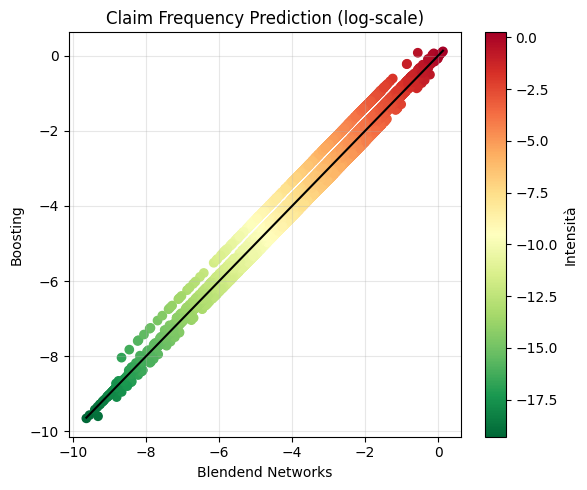

In [11]:
#utilizzo il modello con Depth J0 = 3
z = np.log(prediction_test[2]) + np.log(test_blend_pred)
plt.figure(figsize=(6,5))
sc = plt.scatter(np.log(test_blend_pred),np.log(prediction_test[2]) , c=z, cmap='RdYlGn_r', linewidths=1.)
plt.colorbar(sc, label='Intensità')
plt.plot(np.linspace(np.log(test_blend_pred.min()),np.log(test_blend_pred).max()), np.linspace(np.log(test_blend_pred.min()),np.log(test_blend_pred).max() ), color ="Black")
plt.grid(alpha=.3)
# Label assi e titolo
plt.xlabel("Blendend Networks")
plt.ylabel("Boosting")
plt.title("Claim Frequency Prediction (log-scale)")

plt.show(block = True)


## Combined Actuarial Neural Network (CANN)

<div align="center">
  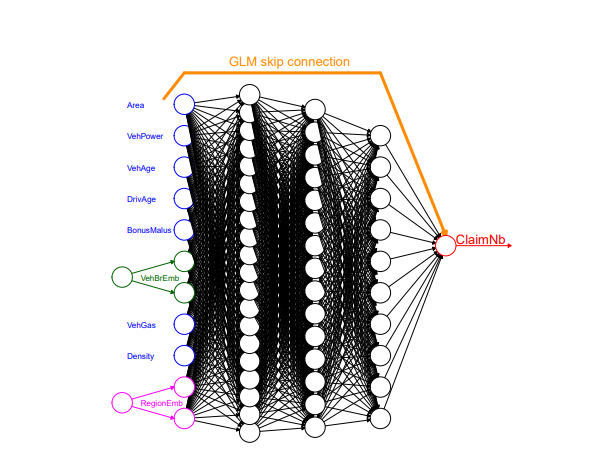
  <p style="font-size:12px; color:gray;">
    Figura 1 — Struttura del modello CANN. Fonte: Schelldorfer & Wüthrich (2019), 
    <i>"Nesting classical actuarial models into neural networks."</i> SSRN 3320525.
  </p>
</div>

In [12]:
#--------------CANN e rielaborazione degli input-----------------------

DATASET = pd.read_csv("freMTPL2freq.csv")
DATASET["AreaGLM"] = DATASET["Area"].astype("category").cat.codes
DATASET["VehPowerGLM"] = np.minimum(DATASET["VehPower"], 9).astype("category")
VehAge = np.concatenate([np.linspace(0,110, num=111).reshape(-1,1), np.array([1]+ [2 for i in range(0,10)]+[3 for i in range(0,100)]).reshape(-1,1)],axis=1)
DATASET["VehAge"] = pd.DataFrame(VehAge[DATASET["VehAge"],1], dtype="int")[0].astype("category")
DriveAge = np.concatenate([np.linspace(18,100,83).reshape(-1,1),np.array([1 for i in range(21-18)]+[2 for i in range(26-21)]
                           +[3 for i in range(31-26)] +[4 for i in range(41-31)]+[5 for i in range(51-41)]+[6 for i in range(71-51)]
                           +[7 for i in range(101-71)]).reshape(-1,1) ] ,axis=1)
DATASET["DrivAgeGLM"] = pd.DataFrame(DriveAge[DATASET["DrivAge"].values-18,1], dtype="int")[0].astype("category")
DATASET["BonusMalus"] = np.minimum(DATASET["BonusMalus"], 150)
DATASET["Density"] = np.log(DATASET["Density"])

random.seed(100)
ll = random.sample(range(DATASET.shape[0]-1), round(DATASET.shape[0]*0.9 ))
train = DATASET.loc[ll,:]
test =  DATASET.drop(index=ll)

#costruzione modello GLM1
try:
    model = smf.glm(formula="ClaimNb ~ VehPowerGLM + C(VehAge, Treatment(reference = 2)) + C(DrivAgeGLM, Treatment(reference = 5)) + BonusMalus + VehBrand + VehGas + Density + C(Region, Treatment(reference = 'R24')) + AreaGLM" ,
                family = sm.families.Poisson(), data = train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
model1 = model.fit()
print(model1.summary())
prediction1 = model1.predict(test, offset= np.log(test["Exposure"]))
loss_glm1 = mean_poisson_deviance(train["ClaimNb"], model1.mu)
oos_loss_glm1 = mean_poisson_deviance(test["ClaimNb"], prediction1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610163
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2701e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.9166e+05
Time:                        18:18:44   Pearson chi2:                 1.43e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01664
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

## Costruzione di un altra forma funzionale per l'input DrivAge

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610165
Model Family:                 Poisson   Df Model:                           46
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2697e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.9157e+05
Time:                        20:04:58   Pearson chi2:                 1.42e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01678
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

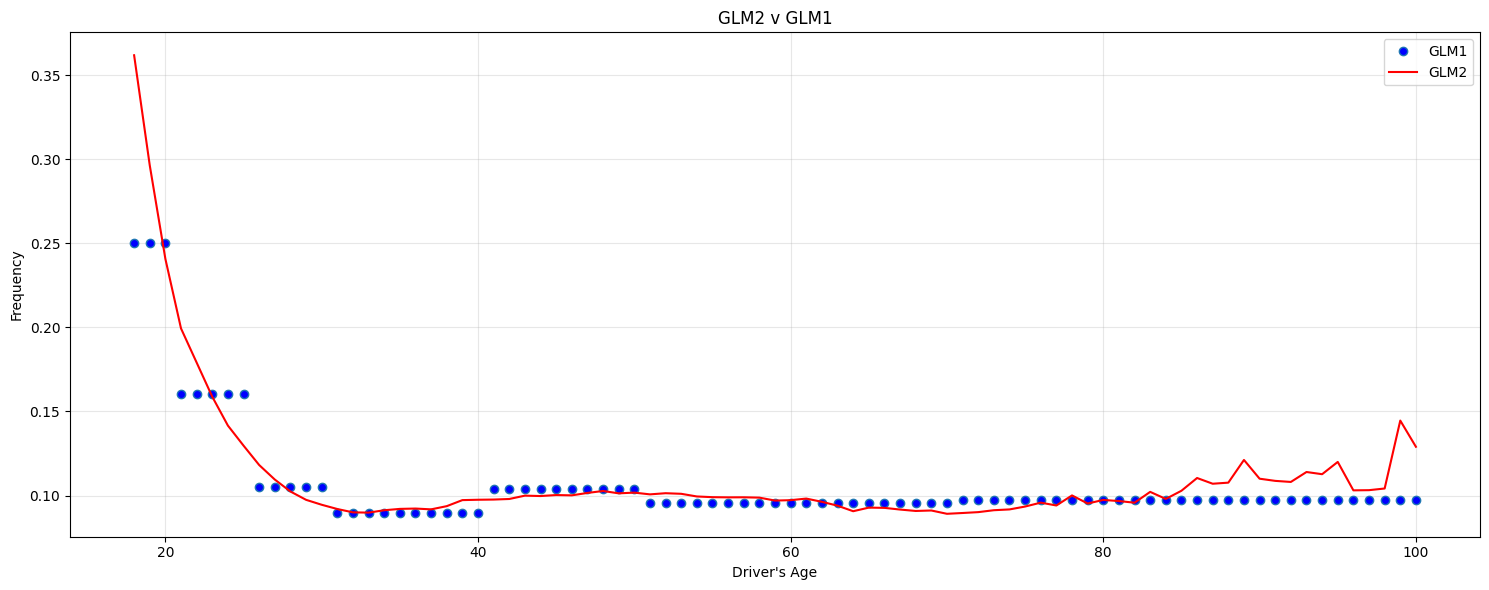

In [14]:
#costruzione di glm2 con DriveAge --> b DriveAge + b log(DriveAge) + sum_{i=1}^4 (DriveAge)^{i}
try:
    model = smf.glm(formula="ClaimNb ~ VehPowerGLM + C(VehAge, Treatment(reference=2)) + DrivAge + np.log(DrivAge) + I(DrivAge**2) + I(DrivAge**3) + I(DrivAge**4) + BonusMalus + VehBrand + VehGas + Density + C(Region, Treatment(reference='R24')) + AreaGLM" ,
                family = sm.families.Poisson(), data = train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
model2 = model.fit()
print(model2.summary())
prediction2 = model2.predict(test, offset= np.log(test["Exposure"]))
loss_glm2 = mean_poisson_deviance(train["ClaimNb"], model2.mu)
oos_loss_glm2 = mean_poisson_deviance(test["ClaimNb"], prediction2)

Tabella_glm = pd.concat([pd.DataFrame(np.array([loss_glm1,loss_glm2])),
                         pd.DataFrame(np.array([oos_loss_glm1,oos_loss_glm2]))],axis = 1)
Tabella_glm.columns = ["is-sample loss", "out-of-sample loss"]
Tabella_glm.index = ["GLM1","GLM2"]
print(Tabella_glm)

fig, ax = plt.subplots()
pivot = pd.pivot_table(pd.concat([train.reset_index(drop=True),pd.DataFrame(model1.mu, columns=["Pred1"])],axis = 1), values=["Pred1","Exposure"], index = "DrivAgeGLM", aggfunc="sum",observed=True)
pivot2 = pd.pivot_table(pd.concat([train.reset_index(drop=True),pd.DataFrame(model2.mu, columns=["Pred2"])],axis = 1), values=["Pred2","Exposure"], index = "DrivAge", aggfunc="sum",observed=True)
pivot2 = pd.concat([pivot2.reset_index(),pd.DataFrame(DriveAge[pivot2.index-18,1], columns=["code"], dtype=int)], axis = 1)
pivot2["class Pred1"] = pivot.loc[pivot2["code"].values, "Pred1"].reset_index(drop=True)
pivot2["exposure Pred1"] = pivot.loc[pivot2["code"].values, "Exposure"].reset_index(drop=True)
ax.plot(pivot2["DrivAge"], pivot2["class Pred1"]/pivot2["exposure Pred1"], label = "GLM1", linestyle = '', marker = "o", markerfacecolor = "blue")
ax.plot(pivot2["DrivAge"], pivot2["Pred2"]/pivot2["Exposure"], label = "GLM2", color = "red" )
ax.set_title("GLM2 v GLM1")
ax.set_xlabel("Driver's Age")
ax.set_ylabel("Frequency")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)

In [15]:
#----- Implementazione di Combined Actuarial Neural Network al modello GLM1
#si applicano anche degli embedding layer

DATASET_NN = pd.read_csv("freMTPL2freq.csv")
DATASET_NN["AreaGLM"] = DATASET_NN["Area"].astype("category").cat.codes
DATASET_NN = DATASET_NN.drop(columns="Area")
DATASET_NN["VehAge"] = np.minimum(DATASET_NN["VehAge"],20)
DATASET_NN["DrivAge"] = np.minimum(DATASET_NN["DrivAge"],90)
DATASET_NN["BonusMalus"] = np.minimum(DATASET_NN["BonusMalus"], 150)
DATASET_NN["Density"] = np.log(DATASET_NN["Density"])
DATASET_NN["VehGas"] = (DATASET_NN["VehGas"] == "Diesel").astype("int")  - .5

#input per embedding layer
DATASET_NN["RegionEmb"] = DATASET_NN["Region"].astype("category").cat.codes
DATASET_NN["VehBrandEmb"] = DATASET_NN["VehBrand"].astype("category").cat.codes
DATASET_NN.drop(columns="Region", inplace=True)
DATASET_NN.drop(columns="VehBrand", inplace=True)


random.seed(100)
ll = random.sample(range(DATASET_NN.shape[0]-1), round(DATASET_NN.shape[0]*0.9 ))
train_NN = DATASET_NN.loc[ll,:]
test_NN = DATASET_NN.drop(index=ll)
X = train_NN.iloc[:,3:]
X_test = test_NN.iloc[:,3:]
y = train_NN["ClaimNb"]

#si scalano i regressori diversi dalle dummy e da exposure tra -1 e 1
scaler = MinMaxScaler()
X_trainSC = pd.DataFrame(2 * scaler.fit_transform(X.iloc[:,0:7])-1)
X_testSC = pd.DataFrame(2 * scaler.transform(X_test.iloc[:,0:7]) -1)
X_trainSC.columns = X_testSC.columns = X.columns[0:7]
X_trainSC.index = X.index
X_testSC.index = X_test.index
X_trainSC = pd.concat([X_trainSC,X.iloc[:,7:]],axis = 1)
X_testSC = pd.concat([X_testSC,X_test.iloc[:,7:]],axis = 1)


#costruzioned el train set per la parte GLM unendo tutte le dummy
vehpower = pd.get_dummies(train["VehPowerGLM"],dtype=int).drop(columns=4)
vehage = pd.get_dummies(train["VehAge"],dtype=int).drop(columns=2)
driveavge = pd.get_dummies(train["DrivAgeGLM"],dtype = int).drop(columns = 5)
vehbrand = pd.get_dummies(train["VehBrand"],dtype = int, drop_first=True)
vehgas = pd.get_dummies(train["VehGas"],dtype=int, drop_first=True)
region = pd.get_dummies(train["Region"],dtype=int).drop(columns="R24")
intercetta = pd.DataFrame(np.ones(shape = train.shape[0]), index=train.index)
train_GLM = pd.concat([intercetta,
                       vehpower,vehage,driveavge,vehbrand,vehgas,region,
                       train["BonusMalus"],train["Density"],train["AreaGLM"]],axis=1)

vehpower_test = pd.get_dummies(test["VehPowerGLM"],dtype=int).drop(columns=4)
vehage_test = pd.get_dummies(test["VehAge"],dtype=int).drop(columns=2)
driveavge_test = pd.get_dummies(test["DrivAgeGLM"],dtype = int).drop(columns = 5)
vehbrand_test = pd.get_dummies(test["VehBrand"],dtype = int, drop_first=True)
vehgas_test = pd.get_dummies(test["VehGas"],dtype=int, drop_first=True)
region_test = pd.get_dummies(test["Region"],dtype=int).drop(columns="R24")
intercetta = pd.DataFrame(np.ones(shape = test.shape[0]), index=test.index)
test_GLM = pd.concat([intercetta,
                      vehpower_test,vehage_test,driveavge_test,vehbrand_test,
                      vehgas_test,region_test,test["BonusMalus"],test["Density"],test["AreaGLM"]],axis=1)

#controllo = np.exp(np.dot(train_GLM.values,model1.params.values.reshape(-1,1))) * train["Exposure"].values.reshape(-1,1)

input_glm = Input(shape = (train_GLM.shape[1],), name = "Regressori GLM", dtype = "float32")
input_NN = Input(shape = (X_trainSC.iloc[:,:-2].shape[1],), name = "Regressori NN", dtype = "float32")
input_region = Input(shape = (1,), name = "Region", dtype="int32")
input_vehbrand = Input(shape = (1,), name = "Vehbrand", dtype="int32")
region_emb = Embedding(input_dim =X_trainSC["RegionEmb"].astype("category").cat.categories.size,output_dim=2)(input_region)
vehbrand_emb = Embedding(input_dim = X_trainSC["VehBrandEmb"].astype("category").cat.categories.size,output_dim=2)(input_vehbrand)
region_emb = Flatten()(region_emb)
vehbrand_emb = Flatten()(vehbrand_emb)
exposure_input = Input(shape = (1,), name = "Exposure")
input = Concatenate()([input_NN, region_emb, vehbrand_emb])
x = Dense(20, activation = "tanh", name = "layer1")(input)
x = Dense(15, activation = "tanh", name = "layer2")(x)
x = Dense(10, activation = "tanh", name = "layer3")(x)
xglm = Dense(1, activation = "linear", name = "glm", use_bias = False)(input_glm)
x = Add()([xglm,x])
x = Dense(1, activation = "exponential", name = "layer4")(x)
output = Multiply()([x, exposure_input])
CANN = Model(inputs = [input_glm,input_NN,input_region,input_vehbrand, exposure_input], outputs=output)
CANN.get_layer("glm").trainable = False
CANN.get_layer("glm").set_weights([model1.params.values.reshape(-1,1)])
CANN.compile(loss = "poisson", optimizer = Nadam())
print(CANN.summary())


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Region (InputLayer)           │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Vehbrand (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 2)              │              44 │ Region[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 2)              │              22 │ Vehbrand[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Regressori NN (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2)                 │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 2)                 │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 11)                │               0 │ Regressori NN[0][0],       │
│                               │                           │                 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer1 (Dense)                │ (None, 20)                │             240 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Regressori GLM (InputLayer)   │ (None, 49)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer2 (Dense)                │ (None, 15)                │             315 │ layer1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ glm (Dense)                   │ (None, 1)                 │              49 │ Regressori GLM[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer3 (Dense)                │ (None, 10)                │             160 │ layer2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 10)                │               0 │ glm[0][0], layer3[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer4 (Dense)                │ (None, 1)                 │              11 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Exposure (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 841 (3.29 KB)

 Trainable params: 792 (3.09 KB)

 Non-trainable params: 49 (196.00 B)

None


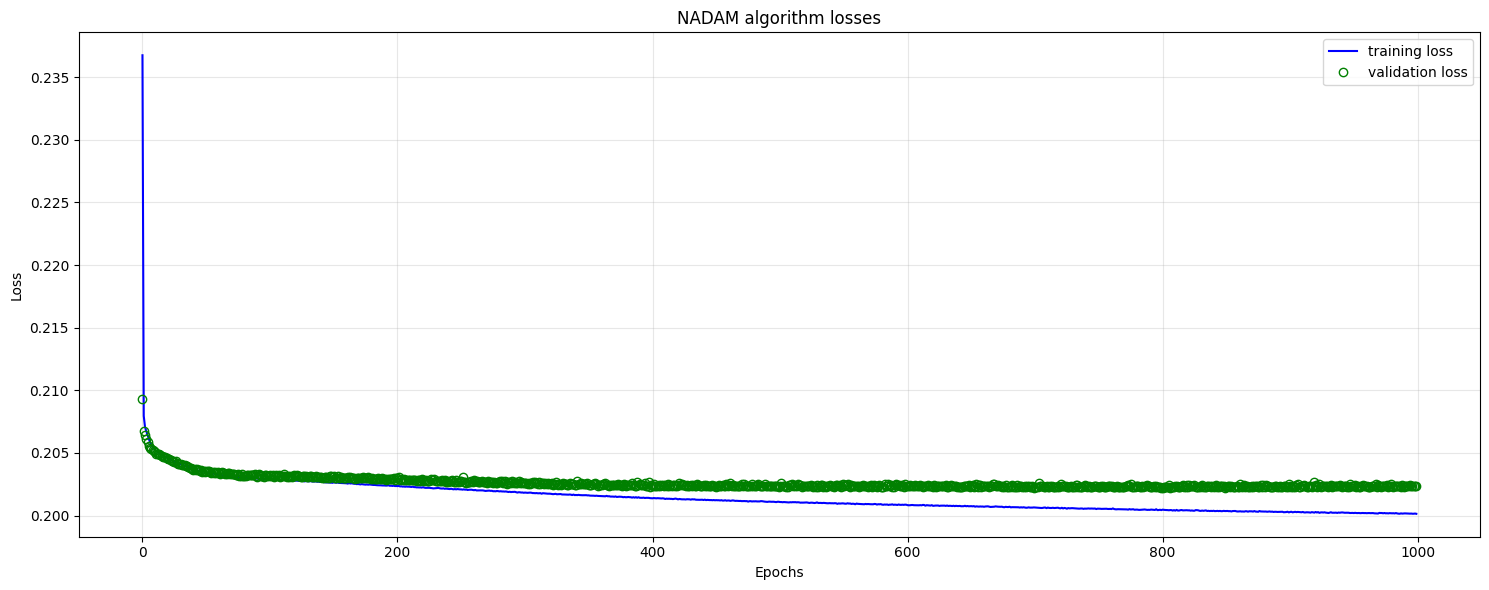

In [16]:
checkpoint_path = "nn.weights_CANN.weights.h5"

#per salvare in automatico i pesi con la validation loss più bassa
checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

fit = CANN.fit(
    x=[train_GLM,X_trainSC.iloc[:,:-2],X_trainSC["RegionEmb"],X_trainSC["VehBrandEmb"],train["Exposure"] ],
    y=y,
    validation_split=0.2,
    batch_size=5000,
    epochs=1000,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
CANN.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


In [17]:
prediction_CANN_train = CANN.predict([train_GLM,X_trainSC.iloc[:,:-2],X_trainSC["RegionEmb"],X_trainSC["VehBrandEmb"],train["Exposure"] ])
prediction_CANN_test = CANN.predict([test_GLM,X_testSC.iloc[:,:-2],X_testSC["RegionEmb"],X_testSC["VehBrandEmb"],test["Exposure"] ])
loss_cann = mean_poisson_deviance(train["ClaimNb"].values, prediction_CANN_train)
oos_loss_cann = mean_poisson_deviance(test["ClaimNb"].values, prediction_CANN_test)
tabella_cann =pd.concat([pd.DataFrame(np.array([loss_glm1,loss_cann])),
                         pd.DataFrame(np.array([oos_loss_glm1, oos_loss_cann]))],axis=1)
tabella_cann.columns = ["in-sample loss","out-of-sample loss"]
tabella_cann.index = ["GLM1", "CANN"]
print(tabella_cann)

19070/19070 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
      in-sample loss  out-of-sample loss
GLM1        0.314087            0.317888
CANN        0.303659            0.311587


## CANN con parte GLM trainabile

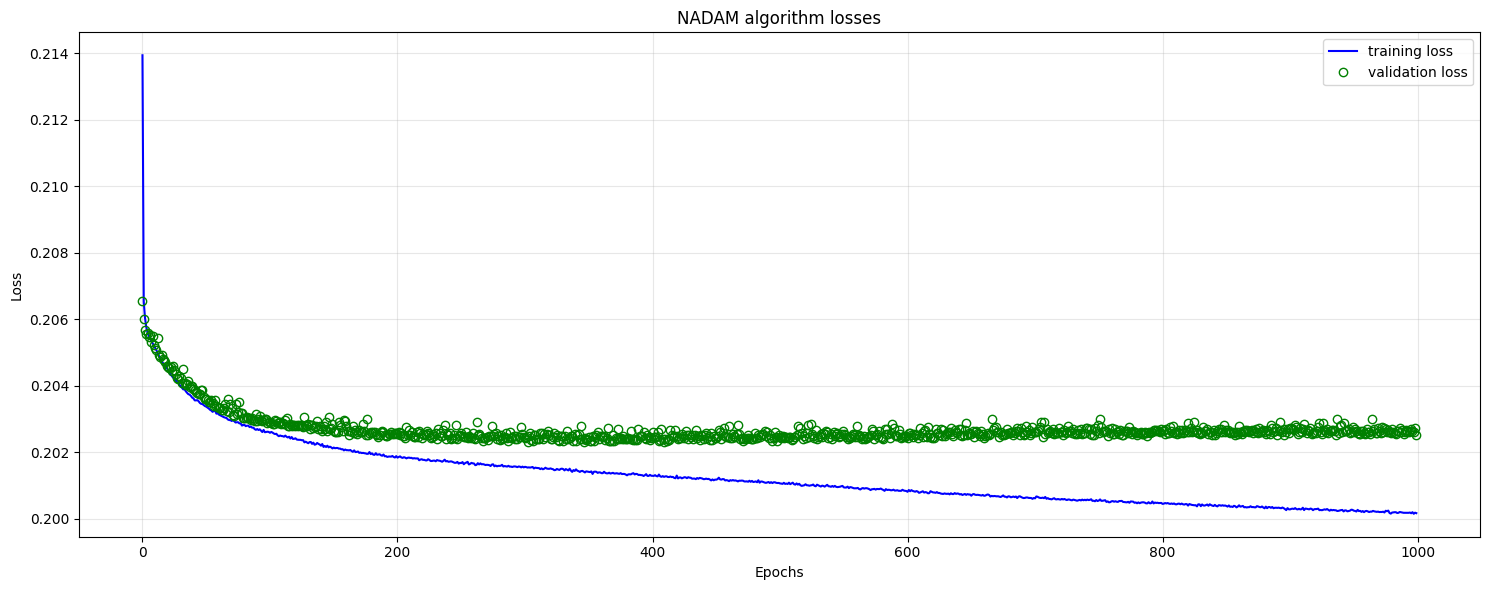

In [18]:
input_glm = Input(shape = (train_GLM.shape[1],), name = "Regressori GLM", dtype = "float32")
input_NN = Input(shape = (X_trainSC.iloc[:,:-2].shape[1],), name = "Regressori NN", dtype = "float32")
input_region = Input(shape = (1,), name = "Region", dtype="int32")
input_vehbrand = Input(shape = (1,), name = "Vehbrand", dtype="int32")
region_emb = Embedding(input_dim =X_trainSC["RegionEmb"].astype("category").cat.categories.size,output_dim=2)(input_region)
vehbrand_emb = Embedding(input_dim = X_trainSC["VehBrandEmb"].astype("category").cat.categories.size,output_dim=2)(input_vehbrand)
region_emb = Flatten()(region_emb)
vehbrand_emb = Flatten()(vehbrand_emb)
exposure_input = Input(shape = (1,), name = "Exposure")
input = Concatenate()([input_NN, region_emb, vehbrand_emb])
x = Dense(20, activation = "tanh", name = "layer1")(input)
x = Dense(15, activation = "tanh", name = "layer2")(x)
x = Dense(10, activation = "tanh", name = "layer3")(x)
xglm = Dense(1, activation = "linear", name = "glm", use_bias = False)(input_glm)
x = Add()([xglm,x])
x = Dense(1, activation = "exponential", name = "layer4")(x)
output = Multiply()([x, exposure_input])
CANN_trainable = Model(inputs = [input_glm,input_NN,input_region,input_vehbrand, exposure_input], outputs=output)
CANN_trainable.get_layer("glm").set_weights([model1.params.values.reshape(-1,1)])
CANN_trainable.compile(loss = "poisson", optimizer = Nadam())

checkpoint_path = "nn.weights_CANN_trainable.weights.h5"

checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

fit = CANN_trainable.fit(
    x=[train_GLM,X_trainSC.iloc[:,:-2],X_trainSC["RegionEmb"],X_trainSC["VehBrandEmb"],train["Exposure"] ],
    y=y,
    validation_split=0.2,
    batch_size=5000,
    epochs=1000,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
CANN_trainable.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)

In [20]:
prediction_CANN_trainable_train = CANN_trainable.predict([train_GLM,X_trainSC.iloc[:,:-2],X_trainSC["RegionEmb"],X_trainSC["VehBrandEmb"],train["Exposure"] ])
prediction_CANN_trainable_test = CANN_trainable.predict([test_GLM,X_testSC.iloc[:,:-2],X_testSC["RegionEmb"],X_testSC["VehBrandEmb"],test["Exposure"] ])
loss_cann_trainable = mean_poisson_deviance(train["ClaimNb"].values, prediction_CANN_trainable_train)
oos_loss_cann_trainable = mean_poisson_deviance(test["ClaimNb"].values, prediction_CANN_trainable_test)

tabella_cann =pd.concat([pd.DataFrame(np.array([loss_glm1,loss_cann,loss_cann_trainable])),
                         pd.DataFrame(np.array([oos_loss_glm1, oos_loss_cann,oos_loss_cann_trainable]))],axis=1)
tabella_cann.columns = ["in-sample loss","out-of-sample loss"]
tabella_cann.index = ["GLM1", "CANN", "CANN trainable"]
print(tabella_cann)


19070/19070 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                in-sample loss  out-of-sample loss
GLM1                  0.314087            0.317888
CANN                  0.303659            0.311587
CANN trainable        0.305319            0.311900
